### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'PMG 287 monitoring'

In [4]:
mixture_paths = {
                'Saccharose hydrolysis': '../data/saccharose_hydrolysis/preprocessed_mixture.csv',
                'PMG 284 monitoring': '../data/PMG_284/preprocessed_mixture.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture_cut_to_regions.csv',
                'Saccharose hydrolysis with full mixture spectrum': '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_mixture.csv',
                'PMG 287 monitoring with full mixture spectrum': '../data/PMG_287_full_mixture_spectrum/preprocessed_mixture_whole.csv',
                }

reagents_paths = {
                'Saccharose hydrolysis': ['../data/saccharose_hydrolysis/preprocessed_saccharose.csv', 
                                            '../data/saccharose_hydrolysis/preprocessed_alpha_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_beta_glucose.csv',
                                            '../data/saccharose_hydrolysis/preprocessed_fructose.csv'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_pentene.csv',
                                      '../data/PMG_284/preprocessed_triethylsilane.csv',
                                      '../data/PMG_284/preprocessed_product.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_hexene.csv',
                                      '../data/PMG_287/preprocessed_triethylsilane.csv',
                                      '../data/PMG_287/preprocessed_product.csv'],
                'Saccharose hydrolysis with full mixture spectrum': [
                                            '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_saccharose.csv', 
                                            '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_alpha_glucose.csv',
                                            '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_beta_glucose.csv',
                                            '../data/saccharose_hydrolysis_full_mixture_spectrum/preprocessed_fructose.csv'
                                                                        ],
                'PMG 287 monitoring with full mixture spectrum': ['../data/PMG_287_full_mixture_spectrum/preprocessed_hexene.csv',
                                                                  '../data/PMG_287_full_mixture_spectrum/preprocessed_triethylsilane.csv',
                                                                  '../data/PMG_287_full_mixture_spectrum/preprocessed_product.csv'],
}

mixture_separators = {
                        'Saccharose hydrolysis': '\t',
                        'PMG 284 monitoring': '\t',
                        'PMG 287 monitoring': '\t',
                        'Saccharose hydrolysis with full mixture spectrum': '\t',
                        'PMG 287 monitoring with full mixture spectrum': '\t'

                        }

reagents_separators = {
                'Saccharose hydrolysis': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t',
                'Saccharose hydrolysis with full mixture spectrum': '\t',
                'PMG 287 monitoring with full mixture spectrum': '\t'
                }

results_paths = {
                'Saccharose hydrolysis': '../results/saccharose_hydrolysis/',
                'PMG 284 monitoring': '../results/PMG_284/',
                'PMG 287 monitoring': '../results/PMG_287/',
                'Saccharose hydrolysis with full mixture spectrum': '../results/saccharose_hydrolysis_full_mixture_spectrum/',
                'PMG 287 monitoring with full mixture spectrum': '../results/PMG_287_full_mixture_spectrum/',
                }

#### Mixture in time

In [5]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis' or experiment_name == 'Saccharose hydrolysis with full mixture spectrum':
    ppm = mixture_time_data.iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring' or experiment_name == 'PMG 287 monitoring with full mixture spectrum':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [6]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [7]:
mixture_time_data.columns = names

In [8]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.trim_negative_intensities()
    sp.normalize()
    return sp

#### Reagents

In [9]:
reagents_spectra = []
for reagent in reagents_paths[experiment_name]:
    reag = pd.read_csv(reagent, sep=reagents_separators[experiment_name], header=None).iloc[:,:2]
    reagents_spectra.append(reag)

In [10]:
reagents_spectra2 = []
for reag in reagents_spectra:
    ppm = reag.iloc[:,0]
    ints = reag.iloc[:,1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    reagents_spectra2.append(sp)
reagents_spectra = reagents_spectra2
del(reagents_spectra2)

In [11]:
for sp in reagents_spectra:
    sp.trim_negative_intensities()
    sp.normalize()

In [12]:
reagents_spectra

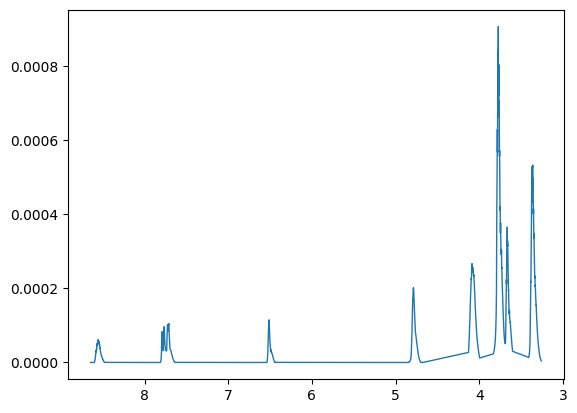

In [13]:
plt.gca().invert_xaxis()
NMRSpectrum.plot(load_spectrum(mixture_time_data, 30), profile=True)
#NMRSpectrum.plot_all(reagents_spectra + [load_spectrum(mixture_time_data, 100)], profile=True)

### Estimation

In [14]:
kappa = 1
kappa_th = 0.1

In [15]:
proportions_in_times = []
noise_proportions_in_times = []
noise = []
noise_in_components = []

for i in range(1, mixture_time_data.shape[1]):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(mixture_time_data, i)
    mix.trim_negative_intensities()
    mix.normalize()
    estimation = estimate_proportions(mix, reagents_spectra, what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    noise.append(estimation['noise'])
    noise_in_components.append(estimation['noise_in_components'])
#     if i>1:
#         assert estimation['common_horizontal_axis'] == common_horizontal_axis
    common_horizontal_axis = estimation['common_horizontal_axis']
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

Set parameter Username
Academic license - for non-commercial use only - expires 2025-12-20


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Proportions:

[0.3172297455979986, 0.4240343789309981, 0.25873587547099886]


Proportion_of_noise_in_components:

0.03357285924999986


This is timepoint 2.

Proportions:

[0.34671619011000043, 0.39852227877500057, 0.25464271606200034]


Proportion_of_noise_in_components:

0.012729237974000017


This is timepoint 3.

Proportions:

[0.3534743799700011, 0.40026390283500124, 0.24574436798600077]


Proportion_of_noise_in_components:

0.018200132468000056


This is timepoint 4.

Proportions:

[0.3456841819860016, 0.3998348280540019, 0.25448098996100116]


Proportion_of_noise_in_components:

0.011634490125000055


This is timepoint 5.

Proportions:

[0.3474271163599987, 0.3977352573059985, 0.25457508542099905]


Proportion_of_noise_in_components:

0.013109036932999949


This is timepoint 6.

Proportions:

[0.3492321476999999, 0.3977717028689999, 0.25268509862299987]


Proportion_of_noise_in_components:

0.013826178942999996


This is timepoint 7.

Proportions:

[0.3451916562530011, 0.3986974

Proportions:

[0.12772294588399974, 0.18444321633999963, 0.6878338377759987]


Proportion_of_noise_in_components:

0.03773475905599993


This is timepoint 54.

Proportions:

[0.12398680771600058, 0.18095207621200082, 0.6950611160720033]


Proportion_of_noise_in_components:

0.03878833681800018


This is timepoint 55.

Proportions:

[0.12033959715600005, 0.17815566645800007, 0.7015047363860003]


Proportion_of_noise_in_components:

0.03929685688300002


This is timepoint 56.

Proportions:

[0.11769125697199943, 0.17477594648399913, 0.7075327965439966]


Proportion_of_noise_in_components:

0.039781686182999806


This is timepoint 57.

Proportions:

[0.11371538066299992, 0.17580745505199985, 0.7104771642849994]


Proportion_of_noise_in_components:

0.040061085563999975


This is timepoint 58.

Proportions:

[0.11307902745000037, 0.17037545806400056, 0.7165455144860023]


Proportion_of_noise_in_components:

0.04165350521800014


This is timepoint 59.

Proportions:

[0.11095659833300028, 0.

In [16]:
len(proportions_in_times)

100

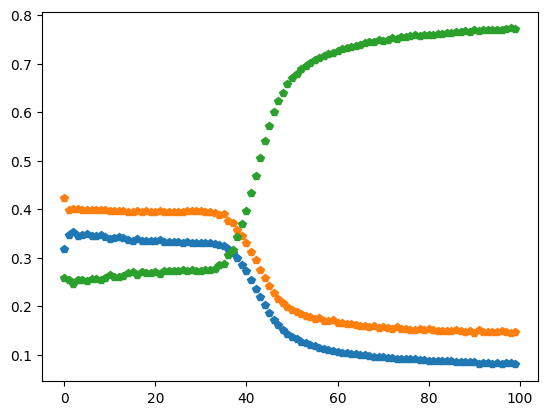

In [17]:
for i in range(len(reagents_spectra)):
    plt.plot(range(len(proportions_in_times)), [prop[i] for prop in proportions_in_times], 'p')

In [18]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(proportions_in_times, f)

In [19]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

In [20]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(common_horizontal_axis, f)

In [21]:
with open(results_paths[experiment_name]+'noise_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise, f)

In [22]:
with open(results_paths[experiment_name]+'noise_in_components_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_in_components, f)